### Data Visualization - Ideal vs Encountered

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math as m

from scipy.spatial.distance import cdist
pd.TimeSeries = pd.Series 

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#performance
import time 
import multiprocessing as mp

### Load Data

In [4]:
set_number = 5

# dir = '~/dataAnalysis/Sprints/Run03/Set0'+str(set_number)+'/'
# dir_save = '/home/ecc/dataAnalysis/Images/'

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
dir_save = '../../../Research/Images/container_odor/'

# wind_load= 'wind0'+str(set_number)+'Run03_Expected_Full.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_InterpolatedXs.hdf' ## bag saved from datavisoptimization 
                                                               ## with expected odor information

# windn = pd.read_hdf(dir+wind_load)
windsm = pd.read_hdf(dir+wind_load_small)

In [69]:
windsm = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set01/wind01Run03_Interpolatedsmall.hdf')
windsm1=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set02/wind02Run03_Interpolatedsmall.hdf')

### Prepare Data

In [70]:
df = pd.DataFrame()
df1 = pd.DataFrame()
df = windsm
df1 = windsm1
dt= df.master_time[1]-df.master_time[0]

In [13]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
odor_position1 = np.array([[df1.xsrc[i],df1.ysrc[i]] for i in range (len(df1.xsrc))]) 

In [71]:
df1.drop(index=df1.index[500:], 
        axis=0, 
        inplace=True)

In [72]:
#summation till Nth particle
eastwest = [np.sum(df1.U[j:])*dt for j in range(0,len(df1))]
northsouth = [np.sum(df1.V[j:])*dt for j in range(0,len(df1))]

In [34]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [19]:
new_df = pd.concat([df,df1[:350]], ignore_index=True)

In [40]:
#summation till Nth particle
eastwest = [np.sum(new_df.U[j:])*dt for j in range(0,len(new_df))]
northsouth = [np.sum(new_df.V[j:])*dt for j in range(0,len(new_df))]


In [73]:
len(eastwest)

500

In [25]:
odor_position = np.array([[new_df.xsrc[i],new_df.ysrc[i]] for i in range (len(new_df.xsrc))]) 

In [26]:
def compute_distance(streakline, odor_position):
    source = np.array([[0,0]])
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    pos = np.where(distance == np.amin(distance))
    nearest_from_streakline.append(np.min(distance))
    if (len(pos[0]) > 1):
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0][0]):]), axis=0)**2, axis=1)))
    else:
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0]):]), axis=0)**2, axis=1)))
        
    distance_along_streakline.append(np.sum(length))

In [27]:
nearest_from_streakline = []
distance_along_streakline = []

for i in range(len(eastwest)-1, 350, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-new_df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-new_df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-350:],northsouth[-350:]]).T   
    compute_distance(wind_pos,odor_pos)

In [28]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        eastwest = np.resize(np.array([eastwest-new_df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-new_df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        
    compute_distance(wind_pos,odor_pos)

In [31]:
## flip containers because above iteration is done in reverse order
new_df['mock'] = np.zeros(len(new_df))
distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
# odor_presence = odor_presence[::-1]
# max_radius = max_radius[::-1]

## storing in the dataframe 
# df['odor_expected'] = odor_presence
new_df['distance_along_streakline'] =  distance_along_streakline
new_df['nearest_from_streakline'] = nearest_from_streakline
# new_df['distance_from_source'] = distance_from_source

In [32]:
new_df

,master_time,xsrc,ysrc,odor,U,V,D,S2,mock,distance_along_streakline,nearest_from_streakline
0,1.603225e+09,-18.793251,-6.125511,0.695307,-0.540000,-0.310000,60.000000,0.620000,0.0,0.000000,0.071329
1,1.603225e+09,-18.886883,-6.156532,0.691311,-0.470000,-0.310000,56.000000,0.560000,0.0,0.062267,0.056546
2,1.603225e+09,-18.980327,-6.186685,0.691126,-0.669999,-0.250000,69.999964,0.709999,0.0,0.118572,0.081440
3,1.603225e+09,-19.069194,-6.195606,0.697219,-0.310001,-0.219999,55.000095,0.380001,0.0,0.190086,0.144754
4,1.603225e+09,-19.158226,-6.204524,0.694326,-0.670000,0.060000,94.999993,0.680000,0.0,0.228100,0.197156
...,...,...,...,...,...,...,...,...,...,...,...
3330,1.603225e+09,-0.715227,1.415467,0.649394,-0.528390,1.198793,156.040249,1.308390,0.0,1.603220,19.915005
3331,1.603225e+09,-0.644601,1.369294,0.639937,-0.449598,1.140201,158.020124,1.230000,0.0,1.456106,19.863786
3332,1.603225e+09,-0.573976,1.323121,0.639988,-0.432391,1.150199,158.900374,1.230996,0.0,1.435175,19.847938
3333,1.603225e+09,-0.504007,1.276963,0.640045,-0.547874,1.161013,154.111379,1.280304,0.0,1.407758,19.804029


In [38]:
len(new_df)-400

2935

### Imagewise Animation Odor_expected vs Odor_encountered (from sensor)

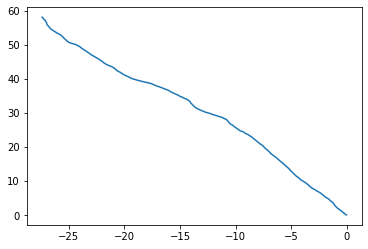

In [79]:
plt.plot(eastwest,northsouth)

In [87]:
eastwest[-350:]

[-19.069879361738327,
 -19.01457621728337,
 -18.929684461702468,
 -18.855712577451825,
 -18.78468045150197,
 -18.710477322207865,
 -18.61643449650901,
 -18.518401616679604,
 -18.41763012276786,
 -18.339587739573894,
 -18.2575754152407,
 -18.174744080580545,
 -18.108400253332928,
 -18.00845784095652,
 -17.914666477717233,
 -17.841765047587227,
 -17.778753246344397,
 -17.714600593127084,
 -17.635849880855073,
 -17.581627039592252,
 -17.505705427806365,
 -17.43773373095273,
 -17.372671565692418,
 -17.301810459773527,
 -17.244758577029693,
 -17.182756862323274,
 -17.120795402209747,
 -17.062773670833103,
 -17.00264118401288,
 -16.929719674270142,
 -16.864657494704712,
 -16.79384674086141,
 -16.741654048104763,
 -16.67076281084585,
 -16.610801415582177,
 -16.554658942361353,
 -16.484697270532134,
 -16.418494124551295,
 -16.332632670877267,
 -16.26071122693806,
 -16.196669183252148,
 -16.12854648160725,
 -16.0488463215807,
 -15.998875144002726,
 -15.951732886312296,
 -15.890741267703032,
 -1

In [67]:
dir_save = '../../../Research/Images/container_wind/'

In [88]:
count = 0
N=2500

#for(upper, lower, step)

for i in range((len(eastwest))-1,350, -1):   
    fig = plt.figure()
#     fig.suptitle('Radius time**0.5*0.01 - Run03_Set05_Small', fontsize =14)
    
    ax = plt.axes (xlim=(-8,15), ylim=(-1,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    
    #TODO: Ignoring 0th point
    
    eastwest = np.resize(np.array([eastwest-df1.U[i]*dt]),(1,i)).flatten() 
    northsouth = np.resize(np.array([northsouth-df1.V[i]*dt]),(1,i)).flatten()

    area = (np.arange(start = i, stop = 0, step = -1)*0.01)**2*4*m.pi #area
    ax.scatter(eastwest, northsouth, c='#FFA500', alpha = 0.3, s=np.sqrt(area), label="Expected Odor")
    
#     if (count<2499):          
#         ax.scatter(df.xsrc[N:i],df.ysrc[N:i], c = df.odor[N:i], cmap = 'inferno', vmin =0 , vmax = 13, s =12, label="Encountered Odor")
#         N=N-1
        
#     else:
#         ax.scatter(df.xsrc[:i],df.ysrc[:i], c = df.odor[:i],cmap = 'inferno', vmin =0 , vmax = 13, s =12, label="Encountered Odor" )

    count+=1
#     lgd=ax.legend(loc='upper right',fancybox=True, shadow=True, bbox_to_anchor=(2.0, 1.03))
    fig.tight_layout()
    fig.savefig(dir_save + "plot" + str(i) + ".jpg")
    plt.close()
        

### Imagewise Animation Odor_Expected vs Time

In [10]:
#perform this locally using multiprocessing
def plot_ts(input):
    i, df = input
    fig = plt.figure()
    ax = plt.axes (xlim=(0,300), ylim=(0,2))
    ax.set_xlabel('Time')
    ax.set_ylabel('Odor Concentration')
    ax.plot(df.sync_time[:i],df.odor_expected[:i])
    fig.savefig(dir_save + "plot" + str(i) + ".jpg")
    plt.close()

In [1]:
if __name__ == '__main__':

    start = time.time()

    inputs = [[i, df] for i in range(len(df))]
    pool = mp.Pool(processes=(mp.cpu_count()-1))
    pool.map(plot_ts, inputs)
    pool.terminate()

    print(time.time()-start)